In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
def redistribute_force(F, L, alpha, F_thr, neighborhood='moore'):
    # Create a copy of the forces to store the new values
    F_new = np.copy(F)
    # List of active sites
    active_sites = []

    # Find active sites
    for i in range(L):
        for j in range(L):
            if F[i, j] >= F_thr:
                active_sites.append((i, j))

    # Redistribute forces from active sites
    for site in active_sites:
        i, j = site
        force_to_redistribute = F[i, j]

        # Define the neighborhood for force redistribution
        if neighborhood == 'moore':
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1),
                         (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        else:  # von Neumann neighborhood
            neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]

        # count no of neighbors 
        neighbors_count = 0    
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                neighbors_count += 1
        
        # Redistribute the force to the neighbors
        for n in neighbors:
            ni, nj = n
            if 0 <= ni < L and 0 <= nj < L:
                F_new[ni, nj] += (alpha * force_to_redistribute)/neighbors_count

        # Set the force of the active site to zero
        F_new[i, j] = 0

    return F_new, active_sites

def simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore'):
    # Initialize the grid with random forces
    F = np.random.rand(L, L) * F_thr
    initial_state = np.copy(F)

    active = True
    while active:
        # Redistribute forces and get list of active sites
        F, active_sites = redistribute_force(F, L, alpha, F_thr, neighborhood)
        # If there are no active sites, break the loop
        active = len(active_sites) > 0

        if not active and n_additions > 0:
            # Locate site with the block closest to slip
            i, j = np.unravel_index(np.argmax(F_thr - F), F.shape)
            # Add the difference to all sites
            F += (F_thr - F[i, j])
            n_additions -= 1
            active = True

    return initial_state, F

def visualize_states(initial_state, final_state, title='Cellular Automata States'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Initial state visualization
    ax1 = axes[0]
    im1 = ax1.imshow(initial_state, cmap='viridis', interpolation='nearest')
    ax1.set_title('Initial State')
    fig.colorbar(im1, ax=ax1, orientation='vertical')

    # Final state visualization
    ax2 = axes[1]
    im2 = ax2.imshow(final_state, cmap='viridis', interpolation='nearest')
    ax2.set_title('Final State')
    fig.colorbar(im2, ax=ax2, orientation='vertical')

    # Overall title and show
    plt.suptitle(title)
    plt.show()




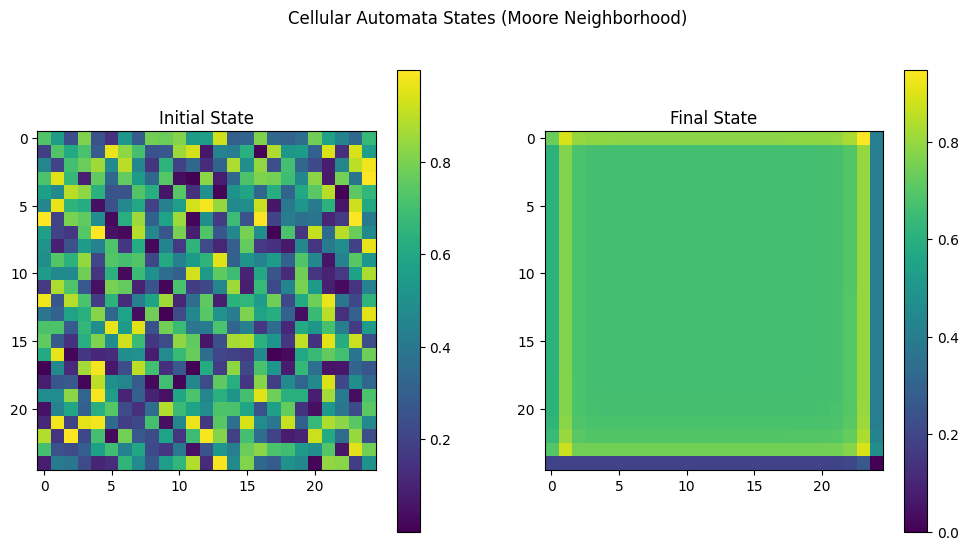

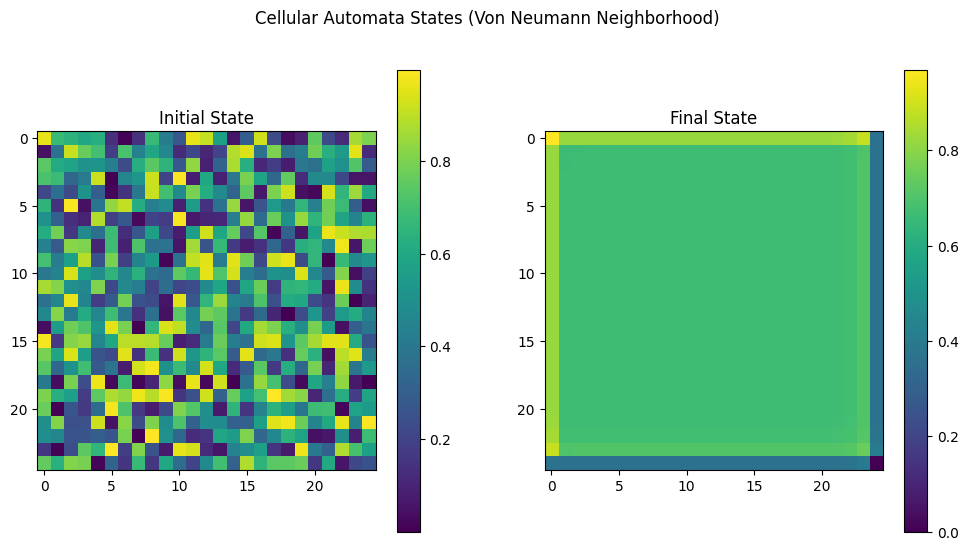

In [76]:
# Parameters
L = 25  # Size of the lattice
alpha = 0.8  # Coupling constant
F_thr = 1.0  # Threshold force
n_additions = 500 # Number of additions of force to the system

# Run the simulation for Moore neighborhood
initial_state_moore, final_state_moore = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='moore')

# Visualize the initial and final states for Moore neighborhood
visualize_states(initial_state_moore, final_state_moore, title='Cellular Automata States (Moore Neighborhood)')

# Run the simulation for Von Neumann neighborhood
initial_state_von, final_state_von = simulate_ca(L, alpha, F_thr, n_additions, neighborhood='von_neumann')

# Visualize the initial and final states for Von Neumann neighborhood
visualize_states(initial_state_von, final_state_von, title='Cellular Automata States (Von Neumann Neighborhood)')